#4 - Classification


<img src="http://static01.nyt.com/images/2012/01/01/realestate/01LIVINGIN_SPAN/01LIVINGIN_SPAN-articleLarge.jpg"/>



<a  style="float: right;" href = 'http://www.nytimes.com/2012/01/01/realestate/ridgewood-queens-living-in-architectural-eye-candy.html'> (SOURCE) </a>

Classification is one of the most important tools used for machine learning and data mining.
In this notebook, we will conduct a classification, a form of deep learning used to classify observations as being within a particular "class" or category. With our dataset, we will be classifying which property "tax class" a building in our dataset is under. These tax classes are categories for what kind of property the real estate is.

In [42]:
%matplotlib inline
import csv
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#NOTE: THIS NOTEBOOK REQUIRES THE PICKLE MADE FROM BOOK 1
##If you have run Book 1, run this:

In [43]:
cleandf = pd.read_pickle('cleandf')

##If you  have *NOT* run Book 2, or there was some issue with the pickle, run this instead:

In [44]:
#cleandf = pd.read_pickle('Data/cleandf')

#Now we begin...

### We create a copy of the data.

In [45]:
dftouse=cleandf.copy()
dftouse['TAX CLASS AT PRESENT'].unique()

array([u'2A', 4, 1, u'2B', u'2C', 2], dtype=object)

We see that our dataset contains 6 unique values for tax class, but 4 of those values fit under tax class 2.

Researching how the city of New York conducts its property tax system, we find that Class 1 refers to residential properties including family homes and condos. We find that Class 2 refers to all other primarily residential properties. Class 4 is for commercial real estate. Tax Class 3 does not show up in our dataset, and this is because Class 3 is relatively rare and only assigned to special franchise properties and utility corporation's real estate. 

## Feature Engineering


Our dataset does not require too much engineering. But it is helpful to categorize some features, as well as construct a few.

We know we must add columns for classifying by tax class. We create a column for each tax bracket (1, 2, and 4). The values of these columns are either 1 or 0, true or false. They are 1 (true) if the property is listed as being part of that specified tax bracket. 

Here we must group the tax classes '2A','2B', and '2C'in with tax class 2. We create columns classifying whether they are in each tax bracket or not. This sets up three columns; one for each tax class.

In [46]:
# consolidating subclasses of 2
dftouse['TAX CLASS AT PRESENT'].replace(u'2A',2, True)
dftouse['TAX CLASS AT PRESENT'].replace(u'2B',2, True)
dftouse['TAX CLASS AT PRESENT'].replace(u'2C',2, True)

# Adding rows for classifying based on Tax Class
dftouse['TAX1'] = (dftouse['TAX CLASS AT PRESENT'].values ==1)
dftouse['TAX2'] = (dftouse['TAX CLASS AT PRESENT'].values ==2)*1
dftouse['TAX4'] = (dftouse['TAX CLASS AT PRESENT'].values ==4)*1
dftouse['TAX CLASS AT PRESENT'].unique()

array([2, 4, 1])

Let's plot a histogram to display the distribution of tax classes in our dataset.

(array([ 76233.,      0.,      0.,  10937.,      0.,      0.,      0.,
             0.,      0.,   4969.]),
 array([ 1. ,  1.3,  1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ]),
 <a list of 10 Patch objects>)

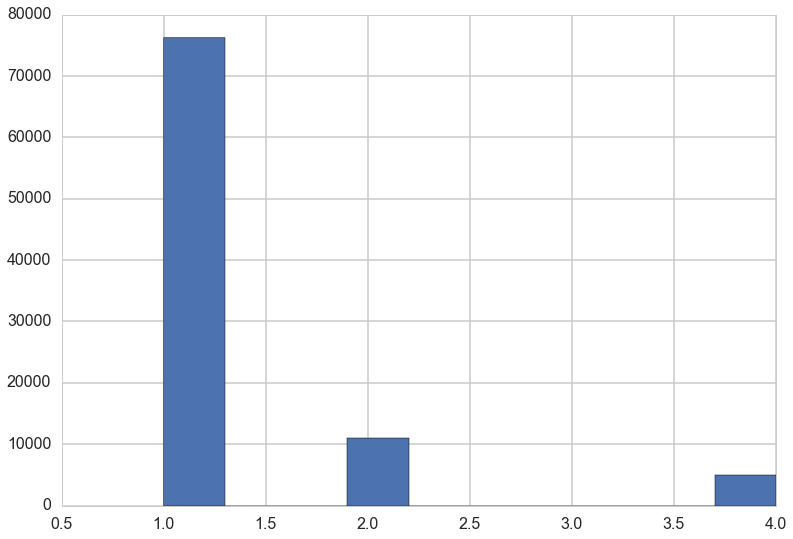

In [47]:
plt.hist(dftouse['TAX CLASS AT PRESENT'].values)

We see above that there are now 3 unique tax classes. To improve our classifier, we bolster our dataset with log features.

In [48]:
dftouse['Log_ResidentialUnits'] = np.log(dftouse['RESIDENTIAL UNITS'].values+1)
dftouse['Log_CommercialUnits'] = np.log(dftouse['COMMERCIAL UNITS'].values+1)
dftouse['Log_TotalUnits'] = np.log(dftouse['TOTAL UNITS'].values+1)
dftouse['Log_GrossSqft'] = np.log(dftouse['GROSS SQUARE FEET'].values)
dftouse['Log_1count'] = np.log(dftouse['1-count'].values)
dftouse['Log_2count'] = np.log(dftouse['2-count'].values)
dftouse['Log_3count'] = np.log(dftouse['3-count'].values)
dftouse['Log_Hospitals'] = np.log(dftouse['Hospitals'].values+1)

It can also be helpful to categorize variables like below. Here, we categorized all of our logarithmic variables. We did not end up using this list of columns, but we did end up using the next list of columns we specified.

In [49]:
LOG_VARS = ['Log_Sale_Price', 'Log_Price_Sqft', '1-mean_log_Pft', '1-median_log_Pft',
            '1-std_log_Pft', '2-median_log_Pft', '2-mean_log_Pft', '2-std_log_Pft', 
            '3-median_log_Pft', '3-mean_log_Pft', '3-std_log_Pft', 'Log_ResidentialUnits', 'Log_CommercialUnits',
            'Log_TotalUnits', 'Log_GrossSqft', 'Log_1count', 'Log_2count', 'Log_3count', 'Log_Hospitals']

Below we list the features that will be standardized and used to train our classifier. This includes numerical data about the property as well as demographic data about the zip code.

In [50]:
continuous_test_features = ['Log_TotalUnits','YEAR BUILT','Log_Sale_Price','1-mean_log_Pft', 
                            '1-std_log_Pft', 'Log_1count','1-median_log_Pft',
                            '2-mean_log_Pft', '2-std_log_Pft', 'Log_2count','2-median_log_Pft',
                            '3-mean_log_Pft', '3-std_log_Pft', 'Log_3count','3-median_log_Pft',
                            'Log_Hospitals', 'High School Graduation Rate', 'College Graduation Rate',
                            'Hispanic', 'Black', 'Asian', 'White','Labor Force', 'Employed', 'Unemployed', 'Population']

Below, we see the percentage of our database that is in each tax bracket. It seems that a disproportionate number of homes sold were in the first tax class, which makes a lot of sense, given the fact that TAX1 refers to single family homes, which are probably going on the market the most often. We see evidence of this in the histogram above displaying the distribution of tax brackets. We should keep this in mind when evaluating the accuracy of our classifiers.

In [51]:
print np.mean(dftouse['TAX1'])
print np.mean(dftouse['TAX2'])
print np.mean(dftouse['TAX4'])

0.827369517794
0.118701092914
0.0539293892923


It looks like about 83 percent of homes sold were of class 1 tax status. This means that if our classifier predicted that a home was class 1 every single time, it would be correct ~83 percent of the time. Initially, 83 percent sounds like very high accuracy, but we should keep in mind that it does not take a great classifier to achieve this level of accuracy for this data.

Before jumping into our classification, let's take a look at the kernel-density distribution of the features we will use for our classification. This way we will be able to check to see if any features jump out as obvious great separators.

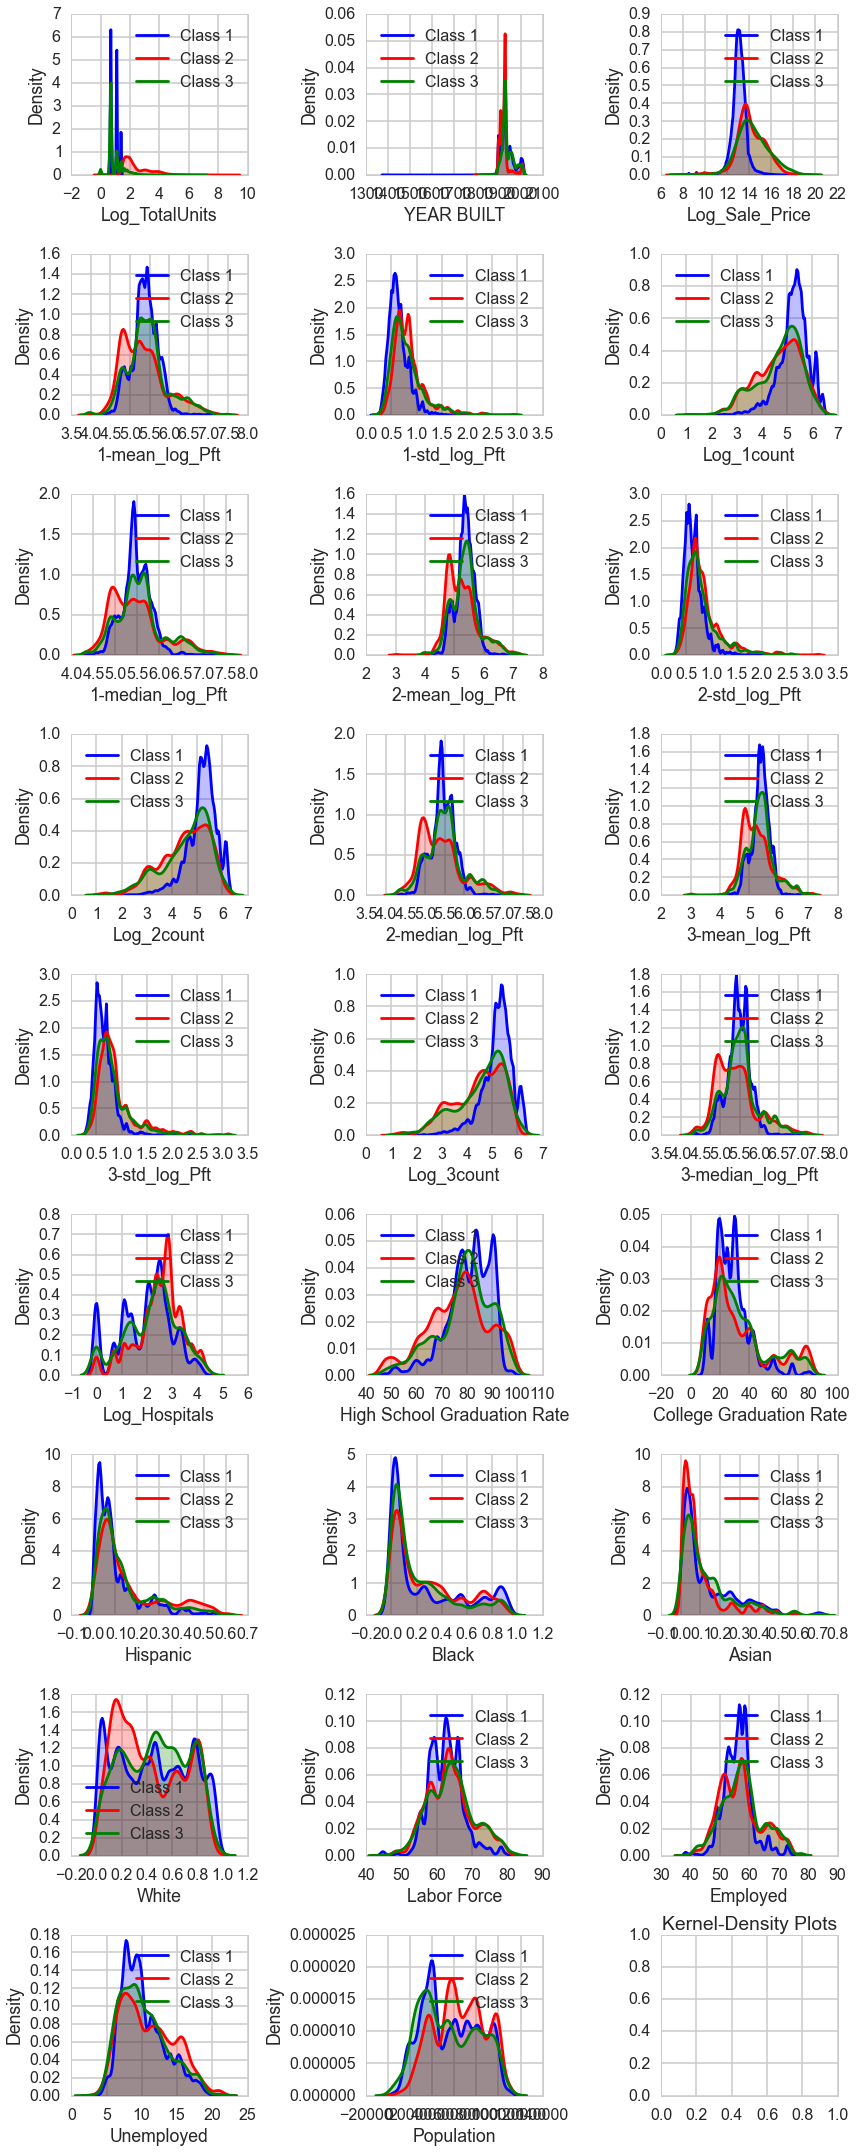

In [52]:
#Kernel-Density Plots
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(12,30),tight_layout=True)

for ax, x in zip(axes.ravel(), dftouse[continuous_test_features]):
    one = dftouse[x][dftouse['TAX1'] == 1]
    two = dftouse[x][dftouse['TAX2'] == 1]
    four = dftouse[x][dftouse['TAX4'] == 1]
    sns.kdeplot(one, ax = ax, shade = True, color = 'b', label = 'Class 1')
    sns.kdeplot(two, ax = ax, shade = True, color = 'r', label = 'Class 2')
    sns.kdeplot(four, ax = ax, shade = True, color = 'g', label = 'Class 3')
    ax.set_xlabel(x)
    ax.set_ylabel('Density')
    plt.title('Kernel-Density Plots')

Due to these kernel-density estimation plots, no great separators jump out at us. We do not see any huge differences in density distribution between classes.

## Constructing test sets, training sets, and standardization.

At this point, we split the data into training and test sets in order to standardize them separately. We will fit our classifier on the training set and then test the values it predicts against those of the test set.

In [53]:
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

In [54]:
# create training and test mask
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

Next, we use the mask to compute the training and test sections of the dataframe. We use our continuous_test_features columns, which we constructed during feature engineering, to fit the training set. We replace all unstandardized values with newly standardized ones. Again, we standardize training and test sets separately in order to reduce risks of dirtying the data with added correlations.

In [55]:
#Standardizing data and constructing test and training sets. Similar to Hw3.
myscaler = StandardScaler(with_mean=True, with_std = True)
training = []
every = []
for x in range(0,len(dftouse)):
    curr_row = dftouse.iloc[x]
    train_row = []
    all_row = []
    for elt in continuous_test_features:
        all_row.append(curr_row[elt])
        if mask[x]:
            train_row.append(curr_row[elt])
    
    if len(train_row) != 0:
        training.append(train_row)
    every.append(all_row)
                 
myscaler.fit(training)
new = myscaler.transform(every)

#take every and put it back into dftouse

standard = {}

c = 0

for elt in continuous_test_features:
    col = []
    for j in range(0,len(new)):
        col.append(new[j][c])
    
    standard[elt] = col
    c += 1

for elt in continuous_test_features:
    dftouse[elt] = standard[elt]

Let's look at our standardized dataframe.

In [56]:
dftouse.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,YEAR,price_ft,Log_Sale_Price,Log_Price_Sqft,1-mean_log_Pft,1-std_log_Pft,1-count,1-median_log_Pft,2-mean_log_Pft,2-std_log_Pft,2-count,2-median_log_Pft,3-mean_log_Pft,3-std_log_Pft,3-count,3-median_log_Pft,Hospitals,Bad Hospitals,High School Graduation Rate,College Graduation Rate,Hispanic,Black,Asian,White,Population,Labor Force,Employed,Unemployed,MONTH,MONTH/YEAR,Q2,Q3,...,11365,11366,11367,11368,11369,11370,11372,11373,11374,11375,11377,11378,11379,11385,11411,11412,11413,11414,11415,11416,11417,11418,11419,11420,11421,11422,11423,11426,11427,11428,11429,11432,11433,11434,11435,11436,11691,11692,11693,TAX1,TAX2,TAX4,Log_ResidentialUnits,Log_CommercialUnits,Log_TotalUnits,Log_GrossSqft,Log_1count,Log_2count,Log_3count,Log_Hospitals
3,1,JAVITS CENTER,14 RENTALS - 4-10 UNIT,2,731,43,S3,419 9 AVENUE,10001,3,1,4,1180,-0.292324,2,S3,8500000,2014-04-30,2014,7203.389831,2.752147,8.882307,3.500451,2.021085,39,3.029325,3.151669,3.089450,28,3.641999,2.904916,1.428041,19,2.812299,3,0,1.360740,2.910729,-0.553491,-0.523732,0.323061,0.546917,-1.390036,1.764152,1.714777,-0.363939,4,"(4, 2014)",1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1,0,1.386294,0.693147,0.765993,7.073270,-2.175930,-2.478004,-2.904729,-0.641743
4,1,FLATIRON,23 LOFT BUILDINGS,4,829,16,L1,31 WEST 27TH STREET,10001,0,17,17,106800,-0.952730,4,L1,65000000,2012-07-16,2012,608.614232,4.819802,6.411185,2.610335,1.637767,19,2.535677,2.184902,1.262735,12,1.884879,0.319865,0.885818,12,0.738214,3,0,1.329066,2.784968,-0.684462,-0.661253,0.335280,0.755324,-1.477012,1.842469,1.829151,-0.490205,7,"(7, 2012)",0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,1,0.000000,2.890372,2.796866,11.578713,-3.223794,-3.676279,-3.527809,-0.641743
5,1,CHELSEA,03 THREE FAMILY DWELLINGS,1,722,67,A4,450 WEST 25TH STREET,10001,1,0,1,5334,-0.952730,1,C0,8500000,2014-12-16,2014,1593.550806,2.752147,7.373720,3.500451,2.021085,39,3.029325,3.151669,3.089450,28,3.641999,2.904916,1.428041,19,2.812299,3,0,1.360740,2.910729,-0.553491,-0.523732,0.323061,0.546917,-1.390036,1.764152,1.714777,-0.363939,12,"(12, 2014)",0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,0,0,0.693147,0.000000,-0.686751,8.581857,-2.175930,-2.478004,-2.904729,-0.641743
8,1,FASHION,29 COMMERCIAL GARAGES,4,759,26,G2,325 WEST 35TH STREET,10001,0,1,1,1760,0.037880,4,G2,13400000,2012-12-18,2012,7613.636364,3.214794,8.937696,2.610335,1.637767,19,2.535677,2.184902,1.262735,12,1.884879,0.319865,0.885818,12,0.738214,3,0,1.329066,2.784968,-0.684462,-0.661253,0.335280,0.755324,-1.477012,1.842469,1.829151,-0.490205,12,"(12, 2012)",0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,1,0.000000,0.693147,-0.686751,7.473069,-3.223794,-3.676279,-3.527809,-0.641743
9,1,FASHION,22 STORE BUILDINGS,4,835,9,K9,49 WEST 33RD STREET,10001,0,3,3,17160,-0.886689,4,K9,13350000,2013-12-30,2013,777.972028,3.210995,6.656691,2.959668,3.216742,28,3.402880,2.788678,1.568915,19,2.730206,2.268392,1.139805,12,1.924404,3,0,1.339624,2.962512,-0.710965,-0.545969,0.289806,0.652546,-1.421877,1.764152,1.714777,-0.363939,12,"(12, 2013)",0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0,1,0.000000,1.386294,0.412208,9.750336,-2.658765,-3.026394,-3.527809,-0.641743


# Classification

Next, we write our classifier. We are going to begin by using support vector machines to classify our data within the three tax brackets. These classifiers will attempt to accurately predict the values in the TAX1, TAX2, and TAX4 columns. Here, we implement Support Vector Classification, which trains data for all three classes. The SVC uses a one-against-one approach to multi-class classification. The SVC can aggregate the results of these classifiers to a decision function with shape (n_samples, n_classes).

In [57]:
#split into test and training sets
clf = svm.SVC()
classifiers = ['TAX1','TAX2', 'TAX4']
X = dftouse[continuous_test_features].values
y = dftouse[classifiers].values
clf = svm.SVC()
Xtrain = X[mask]
Xtest = X[~mask]
ytrain = y[mask]
ytest = y[~mask]

We run a GridSearchCV in order to optimize our classifier wtih the best parameter.

In [58]:
from sklearn.grid_search import GridSearchCV
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
gs = GridSearchCV(clf, param_grid= parameters, cv=5, scoring="accuracy")

Before running our GridSearch we ran into a little problem with our ytrain and ytest sets. Below, we fixed our ytrain and ytest variables, because they were not formatted correctly originally.

In [59]:
fixed = []

for y in ytrain:
    if y[0] == 1:
        fixed.append(0)
    elif y[1] ==1:
        fixed.append(1)
    else:
        fixed.append(2)
        
fixedtest = []

for y in ytest:
    if y[0] == 1:
        fixedtest.append(0)
    elif y[1] ==1:
        fixedtest.append(1)
    else:
        fixedtest.append(2)

Now, we are ready to fit our classifiers and optimize our parameters. We will print out the mean accuracy of each parameter, as well as highlighting the best parameter.

In [60]:
gs.fit(Xtrain, fixed)
gs.best_estimator_, gs.best_params_, gs.best_score_, gs.grid_scores_

(SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
   kernel='rbf', max_iter=-1, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False),
 {'C': 0.1},
 0.86421073848396046,
 [mean: 0.82807, std: 0.00002, params: {'C': 0.0001},
  mean: 0.82807, std: 0.00002, params: {'C': 0.001},
  mean: 0.86421, std: 0.02871, params: {'C': 0.1},
  mean: 0.64916, std: 0.15816, params: {'C': 1},
  mean: 0.52744, std: 0.21612, params: {'C': 10},
  mean: 0.51378, std: 0.21323, params: {'C': 100}])

Our GridSearch shows that the best paramater is C = 1. This will yield the most accurate classifier, which is ~92% accurate on average.

Next, we can calculate the accuracy score of our best classifier. To see just how accurate it is. In other words, how good our classifier is at predicting tax classes.

In [61]:
from sklearn.metrics import accuracy_score
clf=svm.SVC(C=1)
clf.fit(Xtrain, fixed)
ypred2=clf.predict(Xtest)
accuracy_score(ypred2, fixedtest)

0.96273786267274442

We confirm that our SVM classifier is very accurate. It classifies correctly 96 percent of the time. Despite the dataset being 83 percent Class 1, this still shows very, very good accuracy.

# Calibration

We visualize our classifier's predictions using a calibration plot. The calibration plot reveals the bias of a classifier, and does not say much about the classifier's accuracy, since sometimes accuracy is not the best way to determine how good a classifier is. Nonetheless, it does still help us understand how good our classifier is.

In [62]:
# adapted from Lab9
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical Fraction")

    
    #the distribution of P(fresh)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    #calsum = cal['count'].sum()
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    plt.xlabel("Classifier Probability")

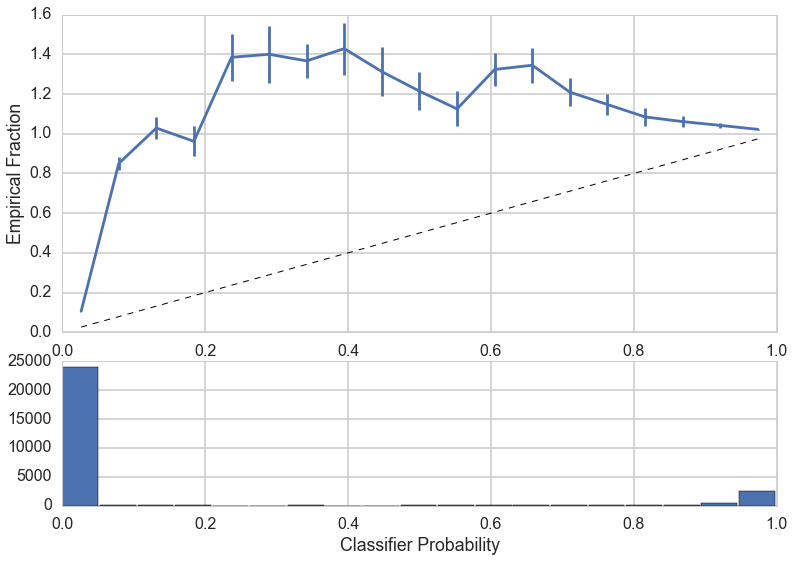

In [63]:
clf=svm.SVC(C=1, probability=True).fit(Xtrain, fixed)
#print("\tPrecision: %1.3f" % precision_score(fixedtest, clf.predict(Xtest)))
calibration_plot(clf, Xtest, fixedtest)

In [64]:
from sklearn.metrics import precision_score
print("\tPrecision: %1.3f" % precision_score(fixedtest, clf.predict(Xtest)))

	Precision: 0.961


/Users/Jimmy/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


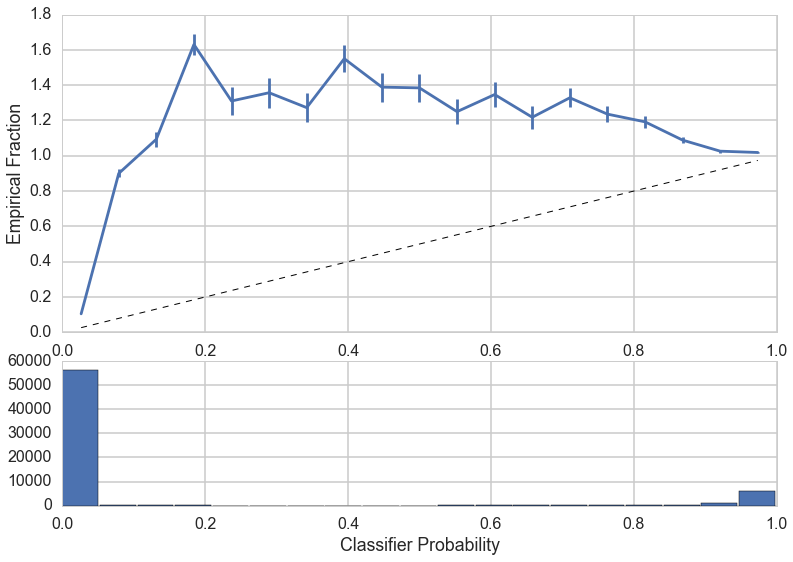

In [65]:
calibration_plot(clf, Xtrain, fixed)

These calibration plots tell a different story than the accuracy metrics we measured earlier. These plots show that the SVC classifier's predictions are not so closely related to the actual tax classes. We see evidence since there does not appear to be a linear relationship between Classifier Probability and Empirical Fraction. Let's try and see if we can find a better classifier.

# Naive Bayes Classifier

Naive Bayes classifier has advantages over SVM. It generally is a much better classifier for skewed data like ours. Naive Bayes is a generative model, meaning that it generates probabilities.

In [66]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
clf=GaussianNB()
clf.fit(Xtrain,fixed)
print "Frac of mislabeled points",float((fixedtest != clf.predict(Xtest)).sum())/len(fixedtest)
confusion_matrix(clf.predict(Xtest),fixedtest)

Frac of mislabeled points 0.158165111063


array([[20600,   720,   832],
       [  996,  2287,   299],
       [ 1229,   296,   383]])

## Calibration plots

We visualize our classifier's predictions through another calibration plot, comparing its predictions with the real data.

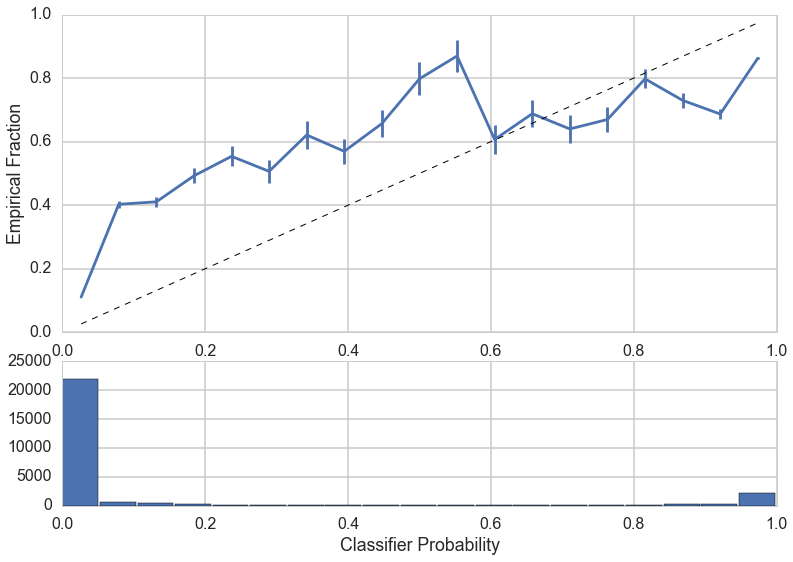

In [67]:
calibration_plot(clf, Xtest, fixedtest)

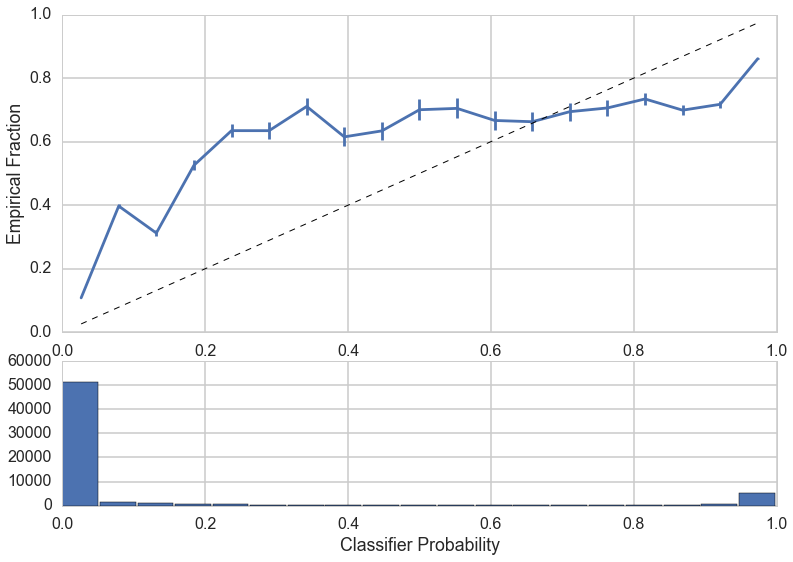

In [68]:
calibration_plot(clf, Xtrain, fixed)

These Calibration plots suggest that Naive-Bayes is a much better classifier for this dataset than support vector machines. The classifier probability distribution is much closer to that of the actual dataset. 

Below we try our hands at a one-dimensional classifier where there is only one class. We see when classifying whether something is in one class or not, we still get very accurate results.

In [69]:
clf=GaussianNB()
y = dftouse['TAX1'].values
Xtrain = X[mask]
Xtest = X[~mask]
ytrain = y[mask]
ytest = y[~mask]
clf.fit(Xtrain,ytrain)
print "Frac of mislabeled points",float((ytest != clf.predict(Xtest)).sum())/len(ytest)
confusion_matrix(clf.predict(Xtest),ytest)

Frac of mislabeled points 0.135409883511


array([[ 3237,  2163],
       [ 1580, 20662]])

In [70]:
clf=GaussianNB()
y = dftouse['TAX2'].values
Xtrain = X[mask]
Xtest = X[~mask]
ytrain = y[mask]
ytest = y[~mask]
clf.fit(Xtrain,ytrain)
print "Frac of mislabeled points",float((ytest != clf.predict(Xtest)).sum())/len(ytest)
confusion_matrix(clf.predict(Xtest),ytest)

Frac of mislabeled points 0.109724332537


array([[22212,   906],
       [ 2127,  2397]])

In [71]:
clf=GaussianNB()
y = dftouse['TAX4'].values
Xtrain = X[mask]
Xtest = X[~mask]
ytrain = y[mask]
ytest = y[~mask]
clf.fit(Xtrain,ytrain)
print "Frac of mislabeled points",float((ytest != clf.predict(Xtest)).sum())/len(ytest)
confusion_matrix(clf.predict(Xtest),ytest)

Frac of mislabeled points 0.139968164388


array([[23259,  1000],
       [ 2869,   514]])

# Comparing Classifiers Using ROC Curve

One way to judge a classifier is by measuring its accuracy. Another way is to plot ROC curves using the classifier. We will explore ROC curves in this section. ROC curves plot the classifier's True-Positive predictions vs. its False-Positive predictions.

Below defines a function for plotting ROC curves.

In [72]:
# From pset 3
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

In [73]:
clfsvm=svm.SVC(C=1, probability=True).fit(Xtrain, fixed)

In [74]:
clfnb=GaussianNB().fit(Xtrain, fixed)

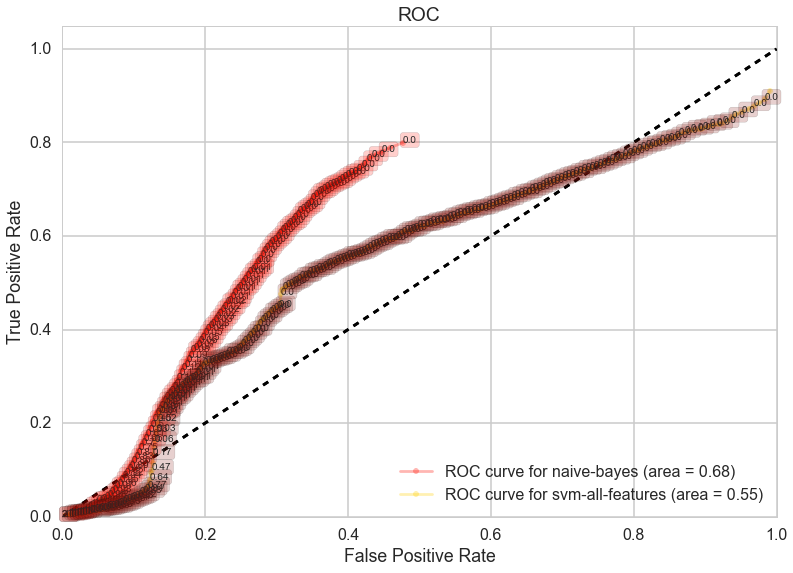

In [75]:
with sns.hls_palette(8, l=.5, s=1):
    ax=make_roc("naive-bayes",clfnb, ytest, Xtest, labe=100, skip=50)
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=100, skip=50)

After observing our ROC curve, it appears as though the Naive-Bayes classifier is a better classifier than the SVM. We can deduce this by observing the greater area under the ROC curve for naive-bayes. Also, we can see that the Naive-Bayes has a higher True Positive Rate for each False Positive Rate. Thus, comparatively, the Naive-Bayes is more successful in predicting tax classes than the support vector machine.